# Import Libraries and Data

In [1]:
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Data Courtesy of https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles

In [2]:
# Import Trip Data Set
for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(filename.replace('.csv', ''))

archive/Overview.xlsx
Overview.xlsx
archive/readin.m
readin.m
archive/TripA01.csv
TripA01
archive/TripA02.csv
TripA02
archive/TripA03.csv
TripA03
archive/TripA04.csv
TripA04
archive/TripA05.csv
TripA05
archive/TripA06.csv
TripA06
archive/TripA07.csv
TripA07
archive/TripA08.csv
TripA08
archive/TripA09.csv
TripA09
archive/TripA10.csv
TripA10
archive/TripA11.csv
TripA11
archive/TripA12.csv
TripA12
archive/TripA13.csv
TripA13
archive/TripA14.csv
TripA14
archive/TripA15.csv
TripA15
archive/TripA16.csv
TripA16
archive/TripA17.csv
TripA17
archive/TripA18.csv
TripA18
archive/TripA19.csv
TripA19
archive/TripA20.csv
TripA20
archive/TripA21.csv
TripA21
archive/TripA22.csv
TripA22
archive/TripA23.csv
TripA23
archive/TripA24.csv
TripA24
archive/TripA25.csv
TripA25
archive/TripA26.csv
TripA26
archive/TripA27.csv
TripA27
archive/TripA28.csv
TripA28
archive/TripA29.csv
TripA29
archive/TripA30.csv
TripA30
archive/TripA31.csv
TripA31
archive/TripA32.csv
TripA32
archive/TripB01.csv
TripB01
archive/TripB0

In [3]:
overview = pd.read_excel("archive/Overview.xlsx")

In [4]:
overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Trip                              70 non-null     object 
 1   Date                              70 non-null     object 
 2   Route/Area                        70 non-null     object 
 3   Weather                           70 non-null     object 
 4   Battery Temperature (Start) [°C]  70 non-null     float64
 5   Battery Temperature (End)         70 non-null     float64
 6   Battery State of Charge (Start)   70 non-null     float64
 7   Battery State of Charge (End)     70 non-null     float64
 8   Unnamed: 8                        70 non-null     float64
 9   Ambient Temperature (Start) [°C]  70 non-null     float64
 10  Target Cabin Temperature          70 non-null     float64
 11  Distance [km]                     70 non-null     float64
 12  Duration [

In [5]:
# Column 8 refers to the change in battery from start to finish. We will rename to Delta Battery
overview.rename(columns={"Unnamed: 8": "Delta Battery"}, inplace=True)

# Column 13 is a empty column so we will delete it
# overview = overview.drop(columns=['Unnamed: 13'])

overview.Date

0     2019-06-25_13-21-14
1     2019-06-25_14-05-31
2     2019-06-28_10-02-15
3     2019-06-28_10-13-30
4     2019-06-28_10-20-26
             ...         
67    2020-01-14_12-55-08
68    2020-01-14_17-59-06
69    2020-01-15_10-43-44
70    2020-01-21_09-15-20
71    2020-02-07_09-32-02
Name: Date, Length: 72, dtype: object

In [6]:
def combine_csv():
    df_main = pd.DataFrame()
    for filename in glob.glob('archive/'+'*.csv'):
        df_trip = pd.read_csv(filename, sep=';', encoding="unicode_escape")
        
        if 'Velocity [km/h]]]' in df_trip.columns:
            df_trip.rename(columns={"Velocity [km/h]]]": "Velocity [km/h]"}, inplace=True)

        match = re.search(r'(Trip[A-Z]\d+).csv', filename)
        if match:
            trip = match.group(1)

        df_trip['Trip'] = trip
            
        df_main = pd.concat([df_main, df_trip])

    df_main.to_csv('All_Trips.csv', index=False)
    return df_main.head(3)

# combine_csv()

# Exploratory Data Analysis

In [7]:
all_trips = pd.read_csv("All_Trips.csv")

In [8]:
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]',
       'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]',
       'Heating Power LIN [W]', 'Requested Heating Power [W]',
       'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]',
       'Heater Current [A]', 'Ambient Temperature [°C]',
       'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]',
       'Trip', 'Unnamed: 23', 'Ambient Temperature Sensor [°C]',
       'Coolant Volume Flow +500 [l/h]',
       'Temperature Coolant Heater Inlet [°C]',
       'Temperature Coolant Heater Outlet [°C]',
       'Temperatu

In [9]:
all_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094793 entries, 0 to 1094792
Data columns (total 50 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   Time [s]                                1094793 non-null  float64
 1   Velocity [km/h]                         1094793 non-null  float64
 2   Elevation [m]                           1094793 non-null  float64
 3   Throttle [%]                            1094793 non-null  float64
 4   Motor Torque [Nm]                       1094793 non-null  float64
 5   Longitudinal Acceleration [m/s^2]       1094793 non-null  float64
 6   Regenerative Braking Signal             1094793 non-null  float64
 7   Battery Voltage [V]                     1094793 non-null  float64
 8   Battery Current [A]                     1094793 non-null  float64
 9   Battery Temperature [°C]                1094793 non-null  float64
 10  max. Battery Temperature [°C] 

In [10]:
all_trips = all_trips.drop(columns=['displayed SoC [%]', 'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]',
       'Unnamed: 23', 'Ambient Temperature Sensor [°C]',
       'min. SoC [%]', 'max. SoC [%)', 'Coolant Volume Flow +500 [l/h]',
       'Requested Heating Power [W]', 'Temperature Coolant Heater Inlet [°C]',
       'Heater Voltage [V]', 'Heater Current [A]', 'Temperature Coolant Heater Outlet [°C]',
       'Temperature Heat Exchanger Outlet [°C]', 'Heating Power LIN [W]',
       'Temperature Defrost lateral left [°C]',
       'Temperature Defrost lateral right [°C]',
       'Temperature Defrost central [°C]',
       'Temperature Defrost central left [°C]',
       'Temperature Defrost central right [°C]',
       'Temperature Footweel Driver [°C]',
       'Temperature Footweel Co-Driver [°C]',
       'Temperature Feetvent Co-Driver [°C]',
       'Temperature Feetvent Driver [°C]', 'Temperature Head Co-Driver [°C]',
       'Temperature Head Driver [°C]', 'Temperature Vent right [°C] ',
       'Temperature Vent central right [°C]',
       'Temperature Vent central left [°C]', 'Temperature Vent right [°C]'], axis=1)

all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]',
       'Trip'],
      dtype='object')

In [11]:
all_trips = all_trips.dropna()
all_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1064000 entries, 0 to 1094792
Data columns (total 17 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Time [s]                           1064000 non-null  float64
 1   Velocity [km/h]                    1064000 non-null  float64
 2   Elevation [m]                      1064000 non-null  float64
 3   Throttle [%]                       1064000 non-null  float64
 4   Motor Torque [Nm]                  1064000 non-null  float64
 5   Longitudinal Acceleration [m/s^2]  1064000 non-null  float64
 6   Regenerative Braking Signal        1064000 non-null  float64
 7   Battery Voltage [V]                1064000 non-null  float64
 8   Battery Current [A]                1064000 non-null  float64
 9   Battery Temperature [°C]           1064000 non-null  float64
 10  max. Battery Temperature [°C]      1064000 non-null  float64
 11  SoC [%]                      

In [12]:
all_trips['Regenerative Braking Signal '] = all_trips['Regenerative Braking Signal '].apply(lambda x: 1 if x != 0 else 0)

print(all_trips['Regenerative Braking Signal '].value_counts())

Regenerative Braking Signal 
0    1006883
1      57117
Name: count, dtype: int64


In [13]:
all_trips['Heater Signal'] = all_trips['Heater Signal'].apply(lambda x: 1 if x != 0 else 0)

print(all_trips['Heater Signal'].value_counts())

Heater Signal
1    981358
0     82642
Name: count, dtype: int64


In [14]:
def plot_df_subplots(df, nrows, ncols, figsize=(30,24)):
    ''' Create a subplot of all the factors and their changes across time'''
    factors = list(df.columns)
    plt.figure(figsize=figsize)
    
    for idx, key in enumerate(factors):
        plt.subplot(nrows, ncols, idx+1)
        plt.plot(np.array(range(df.shape[0]))*0.1, df[key])
        plt.ylabel(key)
        plt.grid(True)
        plt.xlabel(factors[0])
        plt.show

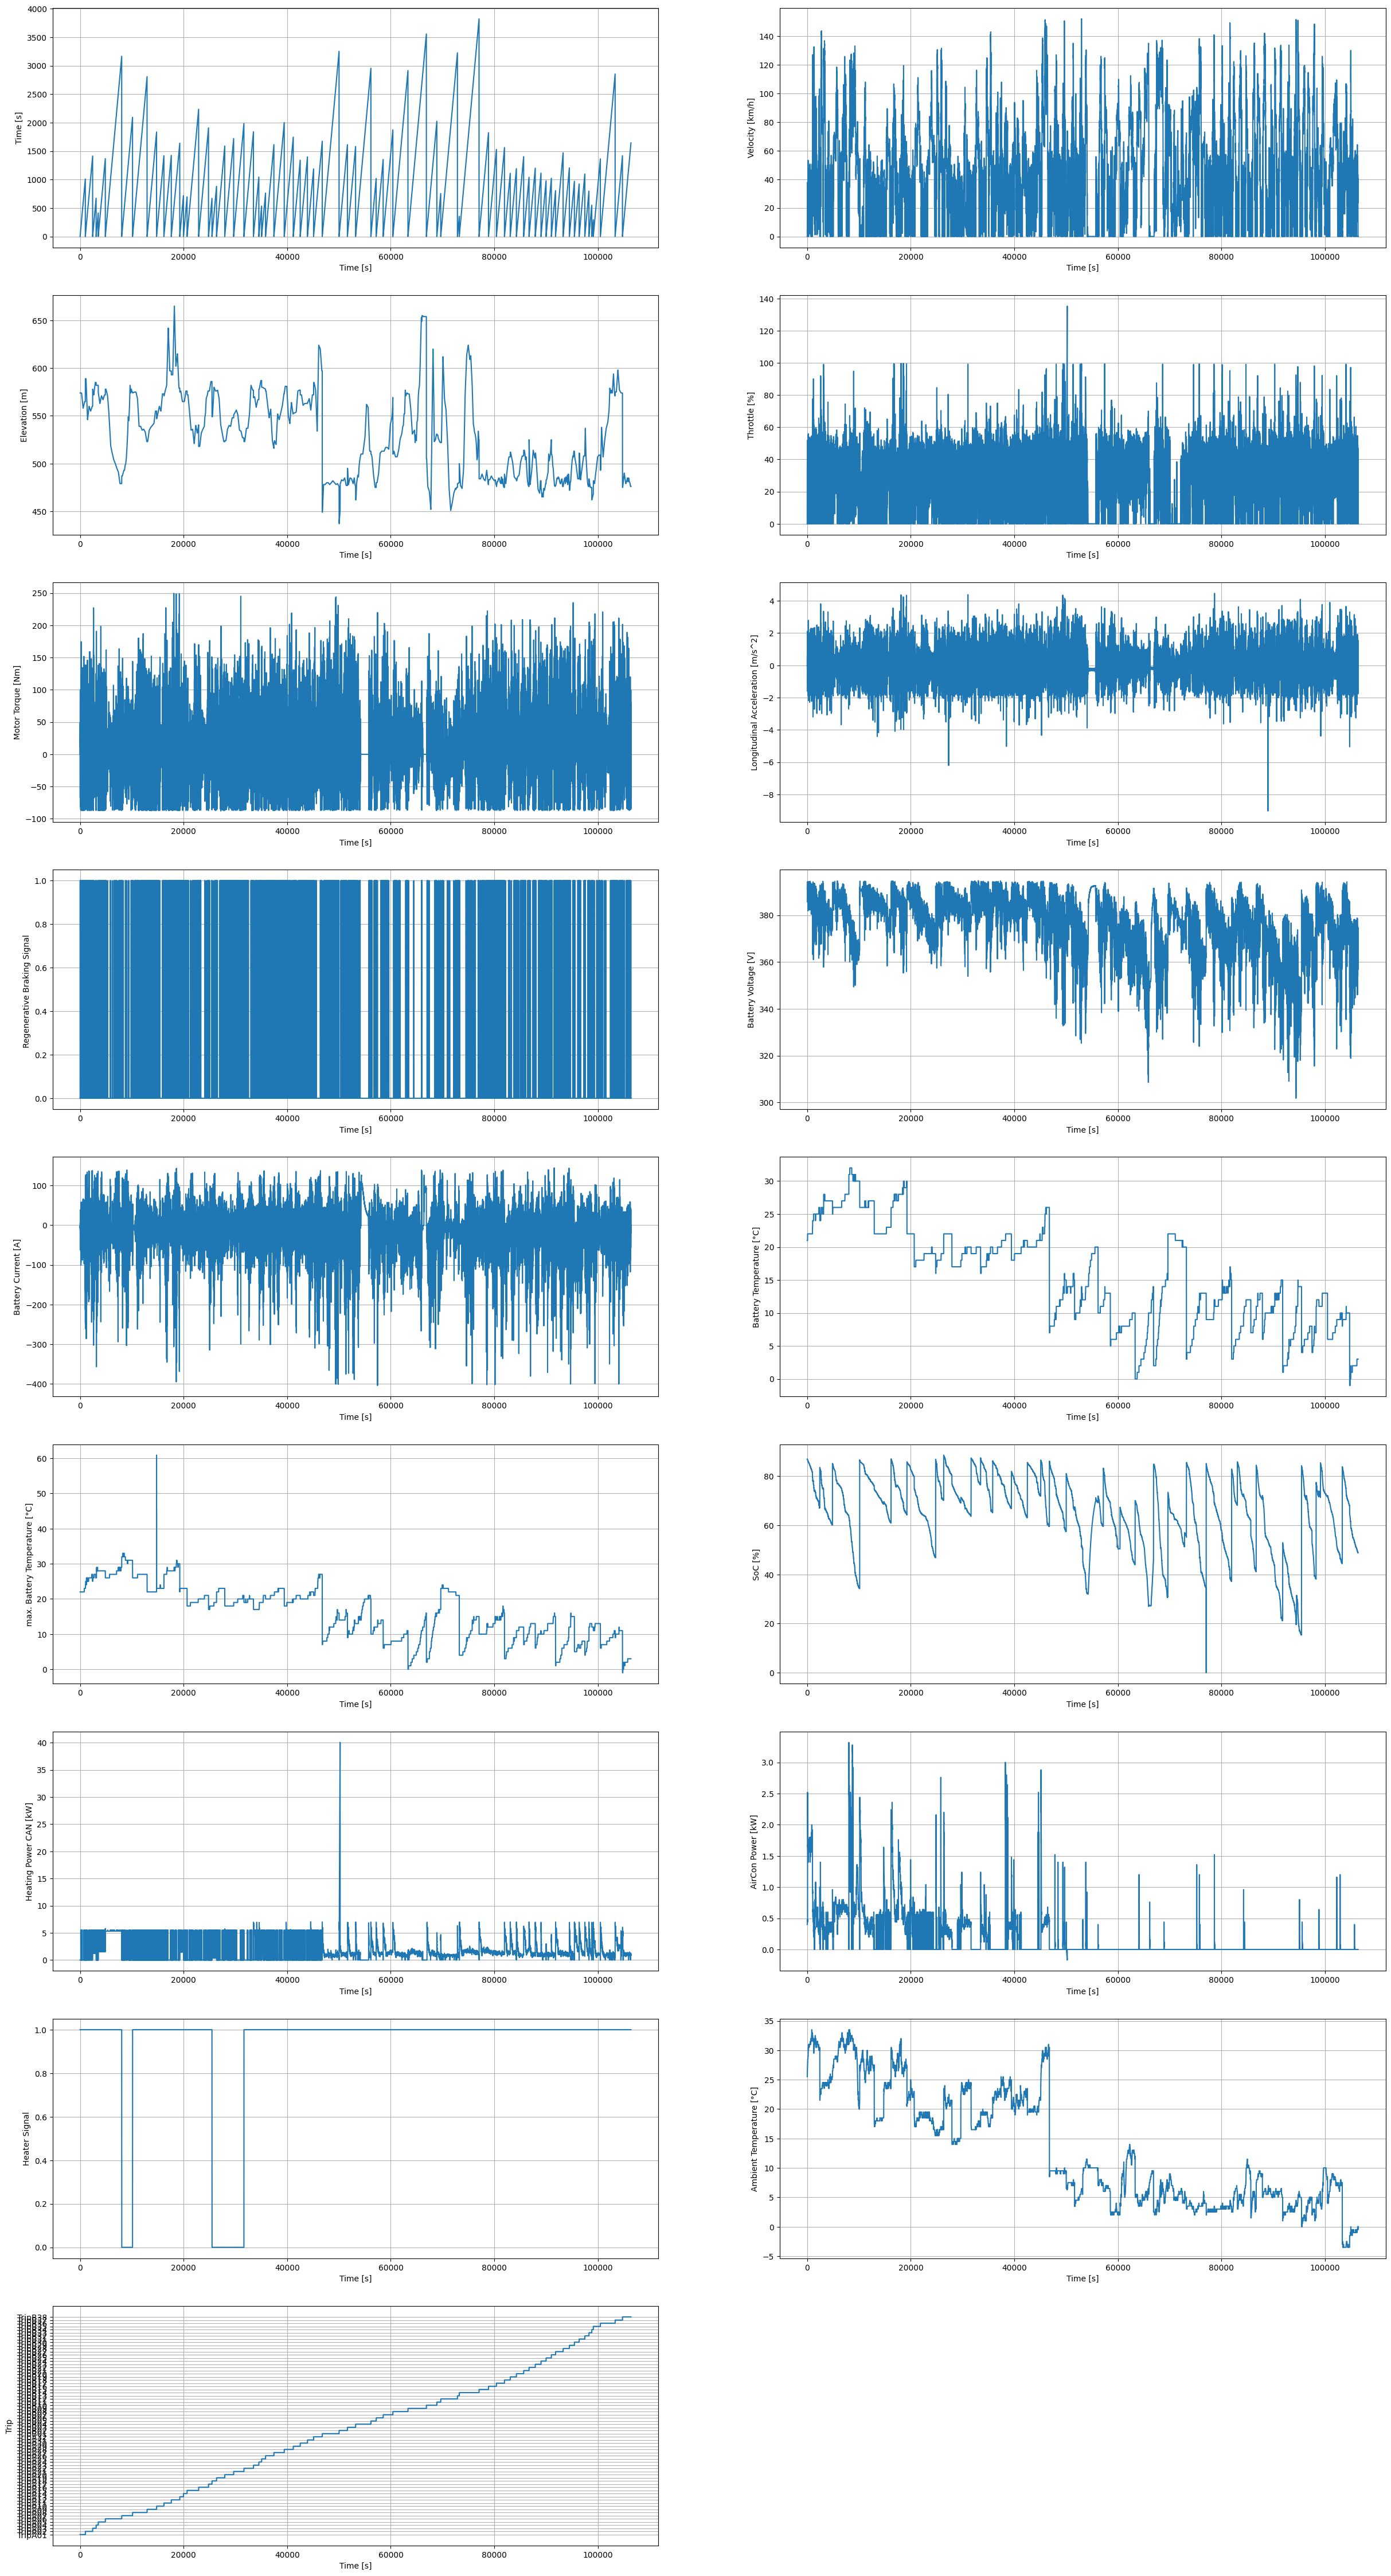

In [15]:
plot_df_subplots(all_trips, nrows=10, ncols=2, figsize=(30,64))

In [16]:
all_trips = all_trips.drop(columns=['Trip'], axis=1)
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]'],
      dtype='object')

<Axes: >

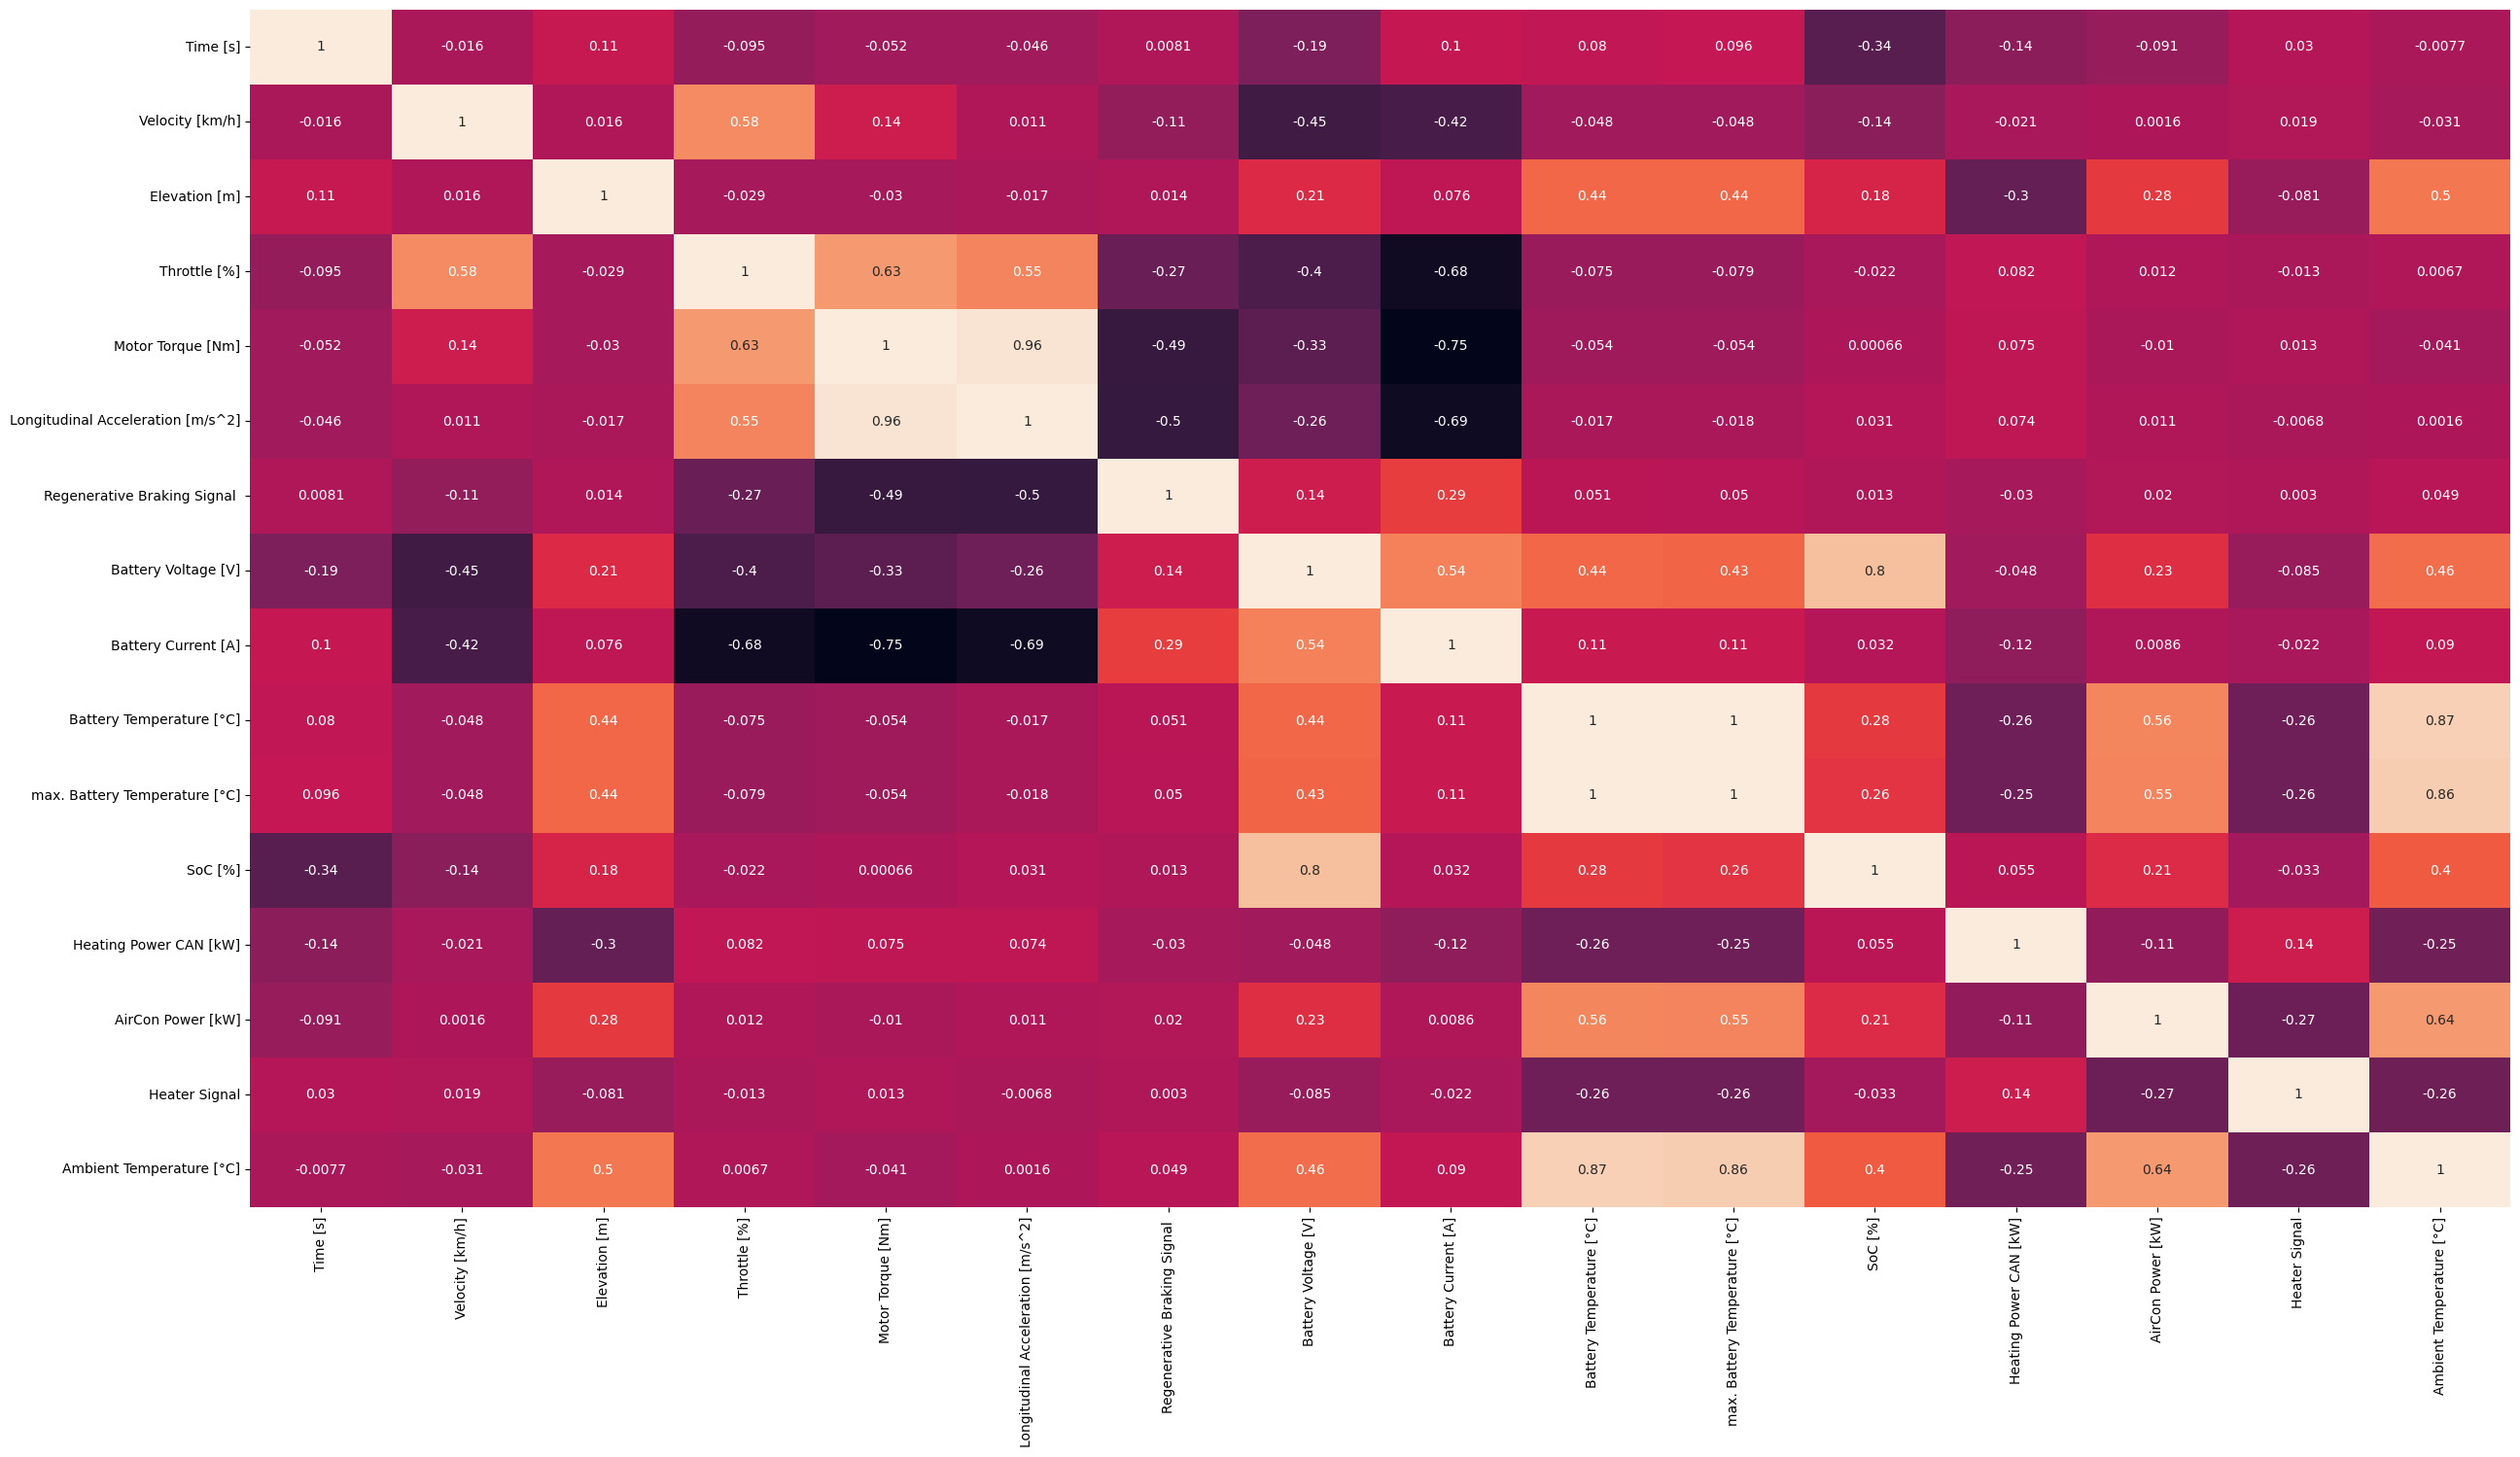

In [17]:
plt.figure(figsize=(30,16))
sns.heatmap(all_trips.corr(), annot=True, cbar=False)

# Modeling

### Train Test split

In [18]:
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]'],
      dtype='object')

In [19]:
# all_trips.set_index("Time [s]", inplace=False)

In [20]:
# Identify predictors and outcome of the regression model.
predictors = ['Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]','Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]']
outcome =  'SoC [%]'

# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = all_trips[predictors]
y = all_trips[outcome]

split = int(len(X) * 0.7)

train_X = X.values[:split]
test_X = X.values[split:]
train_y = y.values[:split]
test_y = y.values[split:]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((744800, 14), (744800,), (319200, 14), (319200,))

## Linear Regression

In [21]:
# Create multiple linear regression model using X and y
# and LinearRegression() function from sklearn (skikit-learn) 
# library.
trip_lm = LinearRegression()
trip_lm.fit(train_X, train_y)

# Display intercept and regression coefficients. Round
# them to 2 decimals.
print('Regression Model for All Trips Training Set')
print()
print('Intercept: ', np.round(trip_lm.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(trip_lm.coef_, 2)}))


Regression Model for All Trips Training Set

Intercept:  -519.93
                            Predictor  Coefficient
0                     Velocity [km/h]         0.07
1                       Elevation [m]         0.01
2                        Throttle [%]        -0.01
3                   Motor Torque [Nm]        -0.05
4   Longitudinal Acceleration [m/s^2]         0.83
5        Regenerative Braking Signal          0.91
6                 Battery Voltage [V]         1.54
7                 Battery Current [A]        -0.21
8            Battery Temperature [°C]         0.52
9       max. Battery Temperature [°C]        -1.27
10             Heating Power CAN [kW]         0.15
11                  AirCon Power [kW]         0.78
12                      Heater Signal         0.78
13           Ambient Temperature [°C]         0.30


In [23]:
test_y.shape

(319200,)

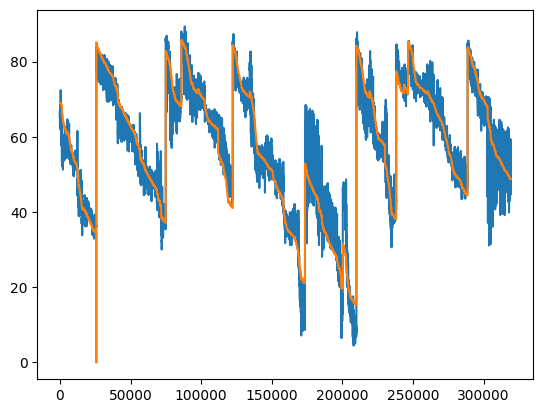

In [25]:
regressor = LinearRegression()
regressor.fit(train_X, train_y)
y_pred_lr = regressor.predict(test_X)

plt.plot(y_pred_lr)
plt.plot(test_y)

In [ ]:
y_pred_lr.shape

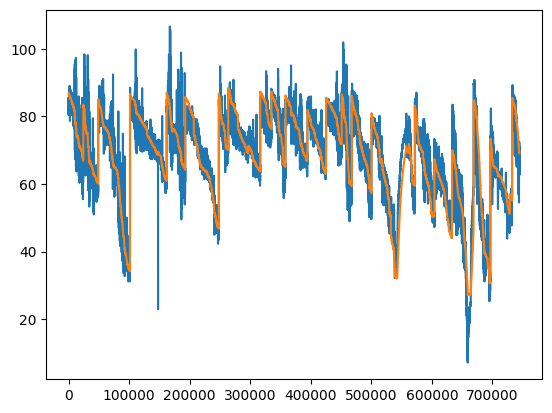

In [26]:
train_pred = regressor.predict(train_X)
plt.plot(train_pred)
plt.plot(train_y)

In [28]:
# Use predict() to score (make) predictions for validation set.
trip_lm_pred = trip_lm.predict(test_X)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
print('Actual, Prediction, and Residual Prices for Validation Set')
result = round(pd.DataFrame({'Actual': test_y,'Predicted': trip_lm_pred, 
                       'Residual': test_y - trip_lm_pred}), 2)
print(result.head(10))

Actual, Prediction, and Residual Prices for Validation Set
   Actual  Predicted  Residual
0    69.1      65.31      3.79
1    69.1      65.47      3.63
2    69.1      65.44      3.66
3    69.1      65.52      3.58
4    69.1      65.73      3.37
5    69.1      65.88      3.22
6    69.1      65.98      3.12
7    69.1      66.16      2.94
8    69.1      66.27      2.83
9    69.1      66.40      2.70


In [30]:
# Use predict() function to make predictions for
# training set.
pred_y = trip_lm.predict(train_X)

# Create prediction performance measures for training set.
r2 = round(r2_score(train_y, pred_y),3)
adj_r2 = round(adjusted_r2_score(train_y, pred_y, trip_lm),3)
aic = round(AIC_score(train_y, pred_y, trip_lm),2)
bic = round(BIC_score(train_y, pred_y, trip_lm),2)

# Display prediction performance measures for training set.
print('Prediction Performance Measures for Training Set')
print('r2 : ', r2)
print('Adjusted r2 : ', adj_r2)
print('AIC : ', aic)
print('BIC : ', bic)
print() 

# Create prediction performance measures for validation set.
r2 = round(r2_score(test_y, trip_lm_pred),3)
adj_r2 = round(adjusted_r2_score(test_y, trip_lm_pred, trip_lm),3)
aic = round(AIC_score(test_y, trip_lm_pred, trip_lm),2)
bic = round(BIC_score(test_y, trip_lm_pred, trip_lm),2)

# Display prediction performance measures for validation set.
print('Prediction Performance Measures for Validation Set')
print('r2 : ', r2)
print('adjusted r2 : ', adj_r2)
print('AIC : ', aic)
print('BIC : ', bic)

Prediction Performance Measures for Training Set
r2 :  0.905
Adjusted r2 :  0.905
AIC :  4185733.59
BIC :  4185917.92

Prediction Performance Measures for Validation Set
r2 :  0.931
adjusted r2 :  0.931
AIC :  1852524.28
BIC :  1852695.05


In [31]:
# Display common accuracy measures for training set.
print('Accuracy Measures for Training Set - All Variables')
regressionSummary(train_y, pred_y)
print()

# Display common accuracy measures for validation set.
print('Accuracy Measures for Validation Set - All Variables')
regressionSummary(test_y, trip_lm_pred)

Accuracy Measures for Training Set - All Variables

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 4.0189
            Mean Absolute Error (MAE) : 2.9239
          Mean Percentage Error (MPE) : -0.3950
Mean Absolute Percentage Error (MAPE) : 4.8391

Accuracy Measures for Validation Set - All Variables

Regression statistics

               Mean Error (ME) : 0.0641
Root Mean Squared Error (RMSE) : 4.4054
     Mean Absolute Error (MAE) : 3.2962


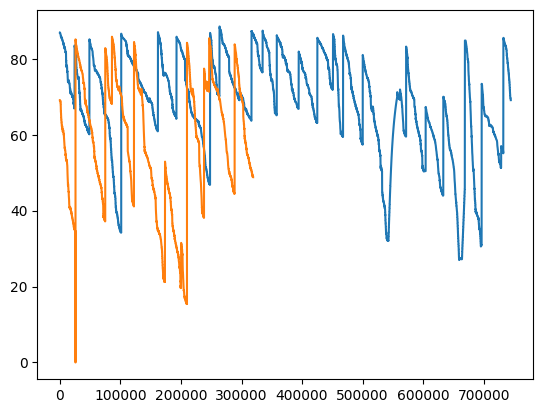

In [32]:
plt.plot(train_y)
plt.plot(test_y)

In [34]:
pred_y = trip_lm.predict(test_X)

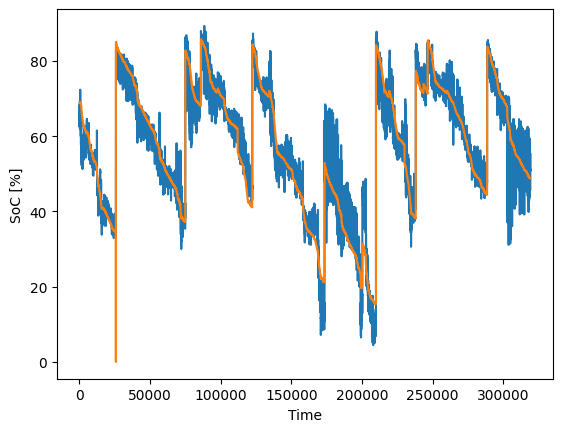

In [35]:
plt.plot(trip_lm_pred)
plt.plot(test_y)
plt.xlabel('Time')
plt.ylabel('SoC [%]')
plt.show()

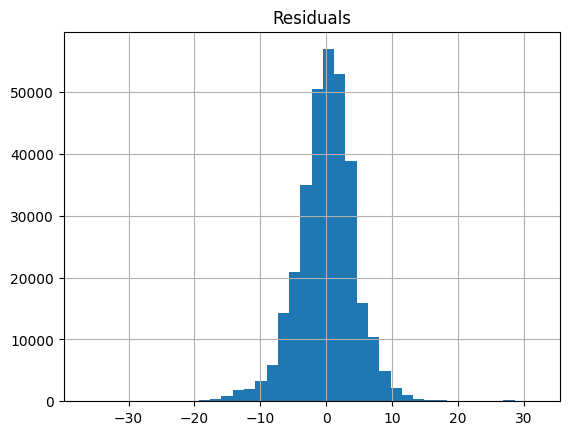

In [37]:
# Identify validation residuals of the regression model
# to check if they have approximately normal distribution.
trip_lm_pred = trip_lm.predict(test_X)
all_residuals = test_y - trip_lm_pred

# Develop data frame for the histogram using hist()
# function.
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=40)

# Show histogram plot. 
# plt.tight_layout()
plt.show()

## Linear Regression 2

In [38]:
# 1. Create a model
regressor = LinearRegression()
# 2. Fit the model
regressor.fit(train_X, train_y)
# 3. Make predicitons with the model
y_pred_lr = regressor.predict(test_X)

In [39]:
print('Regression Model for All Trips Training Set')
print()
print('Intercept: ', np.round(regressor.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(regressor.coef_, 2)}))

Regression Model for All Trips Training Set

Intercept:  -519.93
                            Predictor  Coefficient
0                     Velocity [km/h]         0.07
1                       Elevation [m]         0.01
2                        Throttle [%]        -0.01
3                   Motor Torque [Nm]        -0.05
4   Longitudinal Acceleration [m/s^2]         0.83
5        Regenerative Braking Signal          0.91
6                 Battery Voltage [V]         1.54
7                 Battery Current [A]        -0.21
8            Battery Temperature [°C]         0.52
9       max. Battery Temperature [°C]        -1.27
10             Heating Power CAN [kW]         0.15
11                  AirCon Power [kW]         0.78
12                      Heater Signal         0.78
13           Ambient Temperature [°C]         0.30


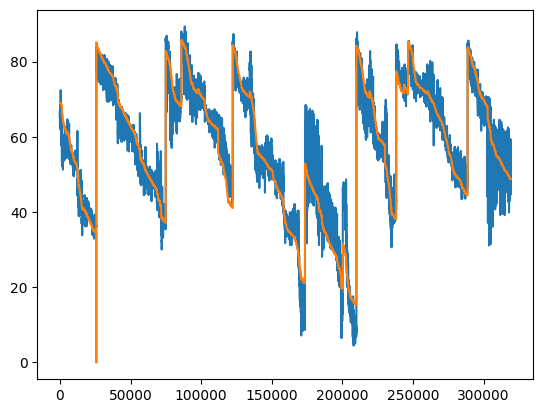

In [40]:
plt.plot(y_pred_lr)
plt.plot(test_y)

## Neural Network - TensorFlow

In [41]:
# 1. Create a model
regressor1 = Sequential([
    layers.Dense(14),
    layers.Dense(7),
    layers.Dense(1),
])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# 2. Compile a model
regressor1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.mae,
                  metrics=["mae"])


In [42]:

# 3. Fit a model
regressor1.fit(train_X, train_y, epochs=20, callbacks=[callback], verbose=True)

Epoch 1/20
23275/23275 [==============================] - 15s 636us/step - loss: 8.1876 - mae: 8.1876
Epoch 2/20
23275/23275 [==============================] - 15s 638us/step - loss: 7.8330 - mae: 7.8330
Epoch 3/20
23275/23275 [==============================] - 14s 621us/step - loss: 7.5896 - mae: 7.5896
Epoch 4/20
23275/23275 [==============================] - 15s 640us/step - loss: 7.2950 - mae: 7.2950
Epoch 5/20
23275/23275 [==============================] - 14s 621us/step - loss: 7.1110 - mae: 7.1110
Epoch 6/20
23275/23275 [==============================] - 14s 618us/step - loss: 6.8621 - mae: 6.8621
Epoch 7/20
23275/23275 [==============================] - 14s 616us/step - loss: 6.5380 - mae: 6.5380
Epoch 8/20
23275/23275 [==============================] - 15s 625us/step - loss: 6.1520 - mae: 6.1520
Epoch 9/20
23275/23275 [==============================] - 14s 608us/step - loss: 5.7618 - mae: 5.7618
Epoch 10/20
23275/23275 [==============================] - 14s 608us/step - loss: 

In [43]:
# 4. Validate the model
y_pred_nn = regressor.predict(test_X)

Text(0, 0.5, 'SoC [%]')

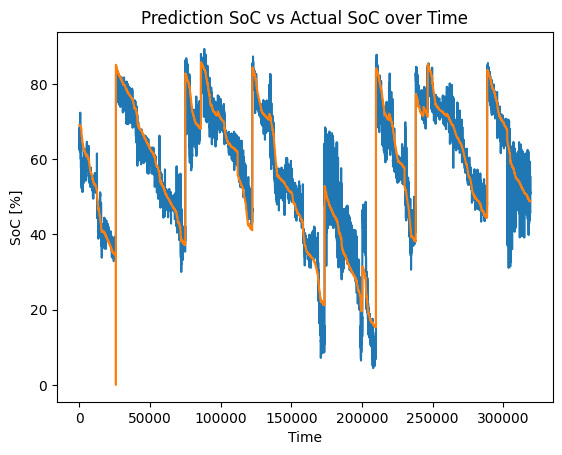

In [44]:
plt.plot(y_pred_nn, label='Prediction')
plt.plot(test_y, label='Actual')
plt.title("Prediction SoC vs Actual SoC over Time")
plt.xlabel('Time')
plt.ylabel('SoC [%]')